In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dropout, Dense, GRU, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [6]:
cities = pd.read_csv("cities.csv")
weather = pd.read_csv("weather.csv")

In [7]:
cities

,city,state,lon,lat,koppen,elevation,distance_to_coast,wind,elevation_change_four,elevation_change_eight,avg_annual_precip
0,ABILENE,TX,-99.68000,32.41000,Cfa,545.46,328.89,4.43,66.72,66.72,26.760
1,AKRON_CANTON,OH,-81.44000,40.92000,Dfa,370.43,329.70,4.28,64.66,64.66,44.686
2,ALBANY,NY,-73.80000,42.75000,Dfb,84.99,99.80,3.28,79.31,97.42,44.660
3,ALBUQUERQUE,NM,-106.61000,35.04000,BSk,1619.93,518.82,3.04,112.19,146.77,10.143
4,ALLENTOWN,PA,-75.49000,40.57000,Dfa,117.73,48.40,3.34,44.82,143.50,52.318
...,...,...,...,...,...,...,...,...,...,...,...
231,WINNEMUCCA,NV,-117.80722,40.90194,BSk,1310.73,320.94,2.66,613.42,613.42,12.261
232,WORCESTER,MA,-71.87000,42.27000,Dfb,297.63,45.39,4.01,162.60,183.92,50.936
233,YAKIMA,WA,-120.53480,46.56402,Csb,320.96,135.32,2.03,326.91,326.91,10.210
234,YOUNGSTOWN,OH,-80.67000,41.25000,Dfb,356.86,296.66,3.42,60.92,72.90,46.675


In [8]:
weather

,date_and_time,city,previous_lo,previous_hi,previous_precip,today_lo,today_hi,today_outlook,tomorrow_lo,tomorrow_hi,tomorrow_outlook,date,am_or_pm
0,2021-01-30 07:50:00,ABILENE TX,54.0,64.0,0.00,39.0,70.0,DUST,32.0,60.0,SUNNY,2021-01-30,AM
1,2021-01-30 07:50:00,AKRON CANTON,11.0,25.0,0.00,26.0,30.0,MOCLDY,28.0,30.0,SNOSHW,2021-01-30,AM
2,2021-01-30 07:50:00,ALBANY NY,-2.0,14.0,0.00,-1.0,18.0,SUNNY,9.0,22.0,PTCLDY,2021-01-30,AM
3,2021-01-30 07:50:00,ALBUQUERQUE,32.0,55.0,0.00,26.0,48.0,SUNNY,26.0,50.0,SUNNY,2021-01-30,AM
4,2021-01-30 07:50:00,ALLENTOWN,16.0,25.0,0.00,14.0,29.0,SUNNY,22.0,28.0,SNOW,2021-01-30,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160059,2022-06-01 20:50:00,WILKES BARRE,66.0,85.0,0.33,64.0,78.0,SHWRS,56.0,74.0,PTCLDY,2022-06-01,PM
160060,2022-06-01 20:50:00,WILMINGTON DE,73.0,85.0,0.00,67.0,86.0,TSTRMS,66.0,79.0,SUNNY,2022-06-01,PM
160061,2022-06-01 20:50:00,YAKIMA,49.0,79.0,0.00,55.0,80.0,TSTRMS,55.0,73.0,SHWRS,2022-06-01,PM
160062,2022-06-01 20:50:00,YOUNGSTOWN,67.0,87.0,0.46,58.0,67.0,SHWRS,48.0,73.0,SUNNY,2022-06-01,PM


Notes: 
- Koppen: in general, A = warmest, E = coldest, H = depends on area, with details: https://www.britannica.com/science/Koppen-climate-classification. 

In [9]:
weather.groupby("city").mean(numeric_only = True)

,previous_lo,previous_hi,previous_precip,today_lo,today_hi,tomorrow_lo,tomorrow_hi
city,,,,,,,
ABILENE TX,54.380638,77.174917,0.047402,53.088816,76.658991,53.088816,76.816886
AKRON CANTON,44.111842,60.152412,0.125416,43.517876,59.801733,43.819068,60.225352
ALBANY NY,39.212719,56.498904,0.142626,39.789816,56.515710,39.848321,56.683640
ALBUQUERQUE,46.216246,70.534577,0.012522,45.192849,70.921993,45.186349,71.013001
ALLENTOWN,42.308970,60.825028,0.127666,43.144095,61.219935,43.163597,61.421452
...,...,...,...,...,...,...,...
WILKES BARRE,42.810227,59.755682,0.133054,43.038126,59.849673,43.216776,60.185185
WILMINGTON DE,46.939227,64.608840,0.121995,47.563181,64.336601,47.531590,64.604575
YAKIMA,39.477348,63.692818,0.016000,40.126362,63.165577,40.117647,63.056645


In [10]:
weather[weather["city"] == "ALBANY NY"]

,date_and_time,city,previous_lo,previous_hi,previous_precip,today_lo,today_hi,today_outlook,tomorrow_lo,tomorrow_hi,tomorrow_outlook,date,am_or_pm
2,2021-01-30 07:50:00,ALBANY NY,-2.0,14.0,0.0,-1.0,18.0,SUNNY,9.0,22.0,PTCLDY,2021-01-30,AM
210,2021-01-30 19:50:00,ALBANY NY,-2.0,17.0,0.0,-1.0,23.0,PTCLDY,10.0,26.0,SNOW,2021-01-30,PM
458,2021-01-31 07:50:00,ALBANY NY,-6.0,17.0,0.0,10.0,17.0,PTCLDY,25.0,25.0,SNOW,2021-01-31,AM
494,2021-01-31 19:50:00,ALBANY NY,-6.0,17.0,0.0,9.0,26.0,SNOW,24.0,30.0,SNOW,2021-01-31,PM
749,2021-02-01 07:50:00,ALBANY NY,10.0,17.0,0.0,25.0,25.0,SNOW,21.0,28.0,SNOW,2021-02-01,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...
159246,2022-05-30 20:50:00,ALBANY NY,55.0,88.0,0.0,68.0,90.0,PTCLDY,60.0,73.0,SHWRS,2022-05-30,PM
159454,2022-05-31 08:50:00,ALBANY NY,69.0,88.0,0.0,62.0,89.0,PTCLDY,60.0,73.0,SHWRS,2022-05-31,AM
159574,2022-05-31 20:50:00,ALBANY NY,69.0,92.0,0.0,62.0,69.0,SHWRS,58.0,76.0,SHWRS,2022-05-31,PM
159738,2022-06-01 07:50:00,ALBANY NY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-06-01,AM


### **shape of the dataset:**

#### there are 976 rows each of weathers for 164 different cities from 2021-01-30 to 2022-06-01. Each day has two entries: one at 7:50AM and one at 7:50PM.

### **Next Step:**
#### want to merge datasets. However, the cities dataframe has city and state separated, so put those together and then merge with the weather dataset.

In [11]:
weather = weather.rename(columns={"city": "city_state"})
weather

,date_and_time,city_state,previous_lo,previous_hi,previous_precip,today_lo,today_hi,today_outlook,tomorrow_lo,tomorrow_hi,tomorrow_outlook,date,am_or_pm
0,2021-01-30 07:50:00,ABILENE TX,54.0,64.0,0.00,39.0,70.0,DUST,32.0,60.0,SUNNY,2021-01-30,AM
1,2021-01-30 07:50:00,AKRON CANTON,11.0,25.0,0.00,26.0,30.0,MOCLDY,28.0,30.0,SNOSHW,2021-01-30,AM
2,2021-01-30 07:50:00,ALBANY NY,-2.0,14.0,0.00,-1.0,18.0,SUNNY,9.0,22.0,PTCLDY,2021-01-30,AM
3,2021-01-30 07:50:00,ALBUQUERQUE,32.0,55.0,0.00,26.0,48.0,SUNNY,26.0,50.0,SUNNY,2021-01-30,AM
4,2021-01-30 07:50:00,ALLENTOWN,16.0,25.0,0.00,14.0,29.0,SUNNY,22.0,28.0,SNOW,2021-01-30,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...
160059,2022-06-01 20:50:00,WILKES BARRE,66.0,85.0,0.33,64.0,78.0,SHWRS,56.0,74.0,PTCLDY,2022-06-01,PM
160060,2022-06-01 20:50:00,WILMINGTON DE,73.0,85.0,0.00,67.0,86.0,TSTRMS,66.0,79.0,SUNNY,2022-06-01,PM
160061,2022-06-01 20:50:00,YAKIMA,49.0,79.0,0.00,55.0,80.0,TSTRMS,55.0,73.0,SHWRS,2022-06-01,PM
160062,2022-06-01 20:50:00,YOUNGSTOWN,67.0,87.0,0.46,58.0,67.0,SHWRS,48.0,73.0,SUNNY,2022-06-01,PM


In [12]:
cities["city_state"] = cities["city"] + " " + cities["state"]
cities

,city,state,lon,lat,koppen,elevation,distance_to_coast,wind,elevation_change_four,elevation_change_eight,avg_annual_precip,city_state
0,ABILENE,TX,-99.68000,32.41000,Cfa,545.46,328.89,4.43,66.72,66.72,26.760,ABILENE TX
1,AKRON_CANTON,OH,-81.44000,40.92000,Dfa,370.43,329.70,4.28,64.66,64.66,44.686,AKRON_CANTON OH
2,ALBANY,NY,-73.80000,42.75000,Dfb,84.99,99.80,3.28,79.31,97.42,44.660,ALBANY NY
3,ALBUQUERQUE,NM,-106.61000,35.04000,BSk,1619.93,518.82,3.04,112.19,146.77,10.143,ALBUQUERQUE NM
4,ALLENTOWN,PA,-75.49000,40.57000,Dfa,117.73,48.40,3.34,44.82,143.50,52.318,ALLENTOWN PA
...,...,...,...,...,...,...,...,...,...,...,...,...
231,WINNEMUCCA,NV,-117.80722,40.90194,BSk,1310.73,320.94,2.66,613.42,613.42,12.261,WINNEMUCCA NV
232,WORCESTER,MA,-71.87000,42.27000,Dfb,297.63,45.39,4.01,162.60,183.92,50.936,WORCESTER MA
233,YAKIMA,WA,-120.53480,46.56402,Csb,320.96,135.32,2.03,326.91,326.91,10.210,YAKIMA WA
234,YOUNGSTOWN,OH,-80.67000,41.25000,Dfb,356.86,296.66,3.42,60.92,72.90,46.675,YOUNGSTOWN OH


In [13]:
merged = weather.merge(cities, on="city_state")
merged.head()

,date_and_time,city_state,previous_lo,previous_hi,previous_precip,today_lo,today_hi,today_outlook,tomorrow_lo,tomorrow_hi,...,state,lon,lat,koppen,elevation,distance_to_coast,wind,elevation_change_four,elevation_change_eight,avg_annual_precip
0,2021-01-30 07:50:00,ABILENE TX,54.0,64.0,0.0,39.0,70.0,DUST,32.0,60.0,...,TX,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76
1,2021-01-30 19:50:00,ABILENE TX,54.0,70.0,0.0,38.0,59.0,SUNNY,32.0,60.0,...,TX,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76
2,2021-01-31 07:50:00,ABILENE TX,42.0,70.0,0.0,32.0,59.0,SUNNY,38.0,60.0,...,TX,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76
3,2021-01-31 19:50:00,ABILENE TX,40.0,60.0,0.0,31.0,60.0,SUNNY,38.0,67.0,...,TX,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76
4,2021-02-01 07:50:00,ABILENE TX,31.0,60.0,0.0,37.0,60.0,SUNNY,45.0,67.0,...,TX,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76


# EDA on Dataset

### No Duplicates

In [14]:
np.round(100*merged.duplicated().sum()/len(merged),1)

0.0

### Some Missing Values

In [15]:
merged[pd.isnull(merged).any(axis=1)].shape[0] / len(merged) * 100

8.89344262295082

In [16]:
merged

,date_and_time,city_state,previous_lo,previous_hi,previous_precip,today_lo,today_hi,today_outlook,tomorrow_lo,tomorrow_hi,...,state,lon,lat,koppen,elevation,distance_to_coast,wind,elevation_change_four,elevation_change_eight,avg_annual_precip
0,2021-01-30 07:50:00,ABILENE TX,54.0,64.0,0.0,39.0,70.0,DUST,32.0,60.0,...,TX,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76
1,2021-01-30 19:50:00,ABILENE TX,54.0,70.0,0.0,38.0,59.0,SUNNY,32.0,60.0,...,TX,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76
2,2021-01-31 07:50:00,ABILENE TX,42.0,70.0,0.0,32.0,59.0,SUNNY,38.0,60.0,...,TX,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76
3,2021-01-31 19:50:00,ABILENE TX,40.0,60.0,0.0,31.0,60.0,SUNNY,38.0,67.0,...,TX,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76
4,2021-02-01 07:50:00,ABILENE TX,31.0,60.0,0.0,37.0,60.0,SUNNY,45.0,67.0,...,TX,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19515,2022-05-30 20:50:00,WILMINGTON DE,63.0,89.0,0.0,67.0,94.0,SUNNY,71.0,86.0,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38
19516,2022-05-31 08:50:00,WILMINGTON DE,68.0,89.0,0.0,71.0,94.0,SUNNY,68.0,86.0,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38
19517,2022-05-31 20:50:00,WILMINGTON DE,68.0,95.0,0.0,71.0,85.0,MOCLDY,69.0,84.0,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38
19518,2022-06-01 07:50:00,WILMINGTON DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38


In [17]:
missing = merged[pd.isnull(merged).any(axis=1)]
missing

,date_and_time,city_state,previous_lo,previous_hi,previous_precip,today_lo,today_hi,today_outlook,tomorrow_lo,tomorrow_hi,...,state,lon,lat,koppen,elevation,distance_to_coast,wind,elevation_change_four,elevation_change_eight,avg_annual_precip
24,2021-02-11 07:50:00,ABILENE TX,21.0,28.0,NaN,21.0,30.0,CLOUDY,19.0,28.0,...,TX,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76
36,2021-02-17 07:50:00,ABILENE TX,17.0,23.0,0.07,NaN,NaN,NaN,NaN,NaN,...,TX,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76
47,2021-02-22 19:50:00,ABILENE TX,30.0,72.0,NaN,39.0,78.0,SUNNY,46.0,57.0,...,TX,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76
48,2021-02-23 07:50:00,ABILENE TX,50.0,72.0,NaN,47.0,79.0,SUNNY,35.0,60.0,...,TX,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76
114,2021-03-28 08:53:00,ABILENE TX,47.0,79.0,0.00,43.0,69.0,NaN,56.0,79.0,...,TX,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19491,2022-05-18 19:50:00,WILMINGTON DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38
19492,2022-05-19 07:50:00,WILMINGTON DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38
19493,2022-05-19 19:50:00,WILMINGTON DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38
19499,2022-05-22 20:50:00,WILMINGTON DE,73.0,88.0,NaN,61.0,74.0,MOCLDY,58.0,70.0,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38


In [18]:
missing[missing["city_state"] == "WILMINGTON DE"]

,date_and_time,city_state,previous_lo,previous_hi,previous_precip,today_lo,today_hi,today_outlook,tomorrow_lo,tomorrow_hi,...,state,lon,lat,koppen,elevation,distance_to_coast,wind,elevation_change_four,elevation_change_eight,avg_annual_precip
18552,2021-02-03 07:50:00,WILMINGTON DE,29.0,37.0,NaN,23.0,37.0,SNOSHW,28.0,42.0,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38
18575,2021-02-14 19:50:00,WILMINGTON DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38
18681,2021-04-08 19:50:00,WILMINGTON DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38
18793,2021-06-03 20:50:00,WILMINGTON DE,63.0,79.0,NaN,67.0,81.0,TSTRMS,63.0,88.0,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38
18799,2021-06-06 20:50:00,WILMINGTON DE,68.0,89.0,NaN,70.0,90.0,TSTRMS,74.0,89.0,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19491,2022-05-18 19:50:00,WILMINGTON DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38
19492,2022-05-19 07:50:00,WILMINGTON DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38
19493,2022-05-19 19:50:00,WILMINGTON DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38
19499,2022-05-22 20:50:00,WILMINGTON DE,73.0,88.0,NaN,61.0,74.0,MOCLDY,58.0,70.0,...,DE,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38


In [19]:
missing["city_state"].unique()

array(['ABILENE TX', 'ALBANY NY', 'BURLINGTON VT', 'CHARLESTON SC',
       'CHARLESTON WV', 'COLUMBIA SC', 'COLUMBUS GA', 'COLUMBUS OH',
       'NORFOLK VA', 'PORTLAND ME', 'PORTLAND OR', 'ROCHESTER NY',
       'CONCORD NH', 'HUNTSVILLE AL', 'JACKSON MS', 'SALEM OR',
       'SPRINGFIELD IL', 'SPRINGFIELD MO', 'WASHINGTON DC',
       'WILMINGTON DE'], dtype=object)

#### For 92 rows, Wilmington DE has almost no information about the weather

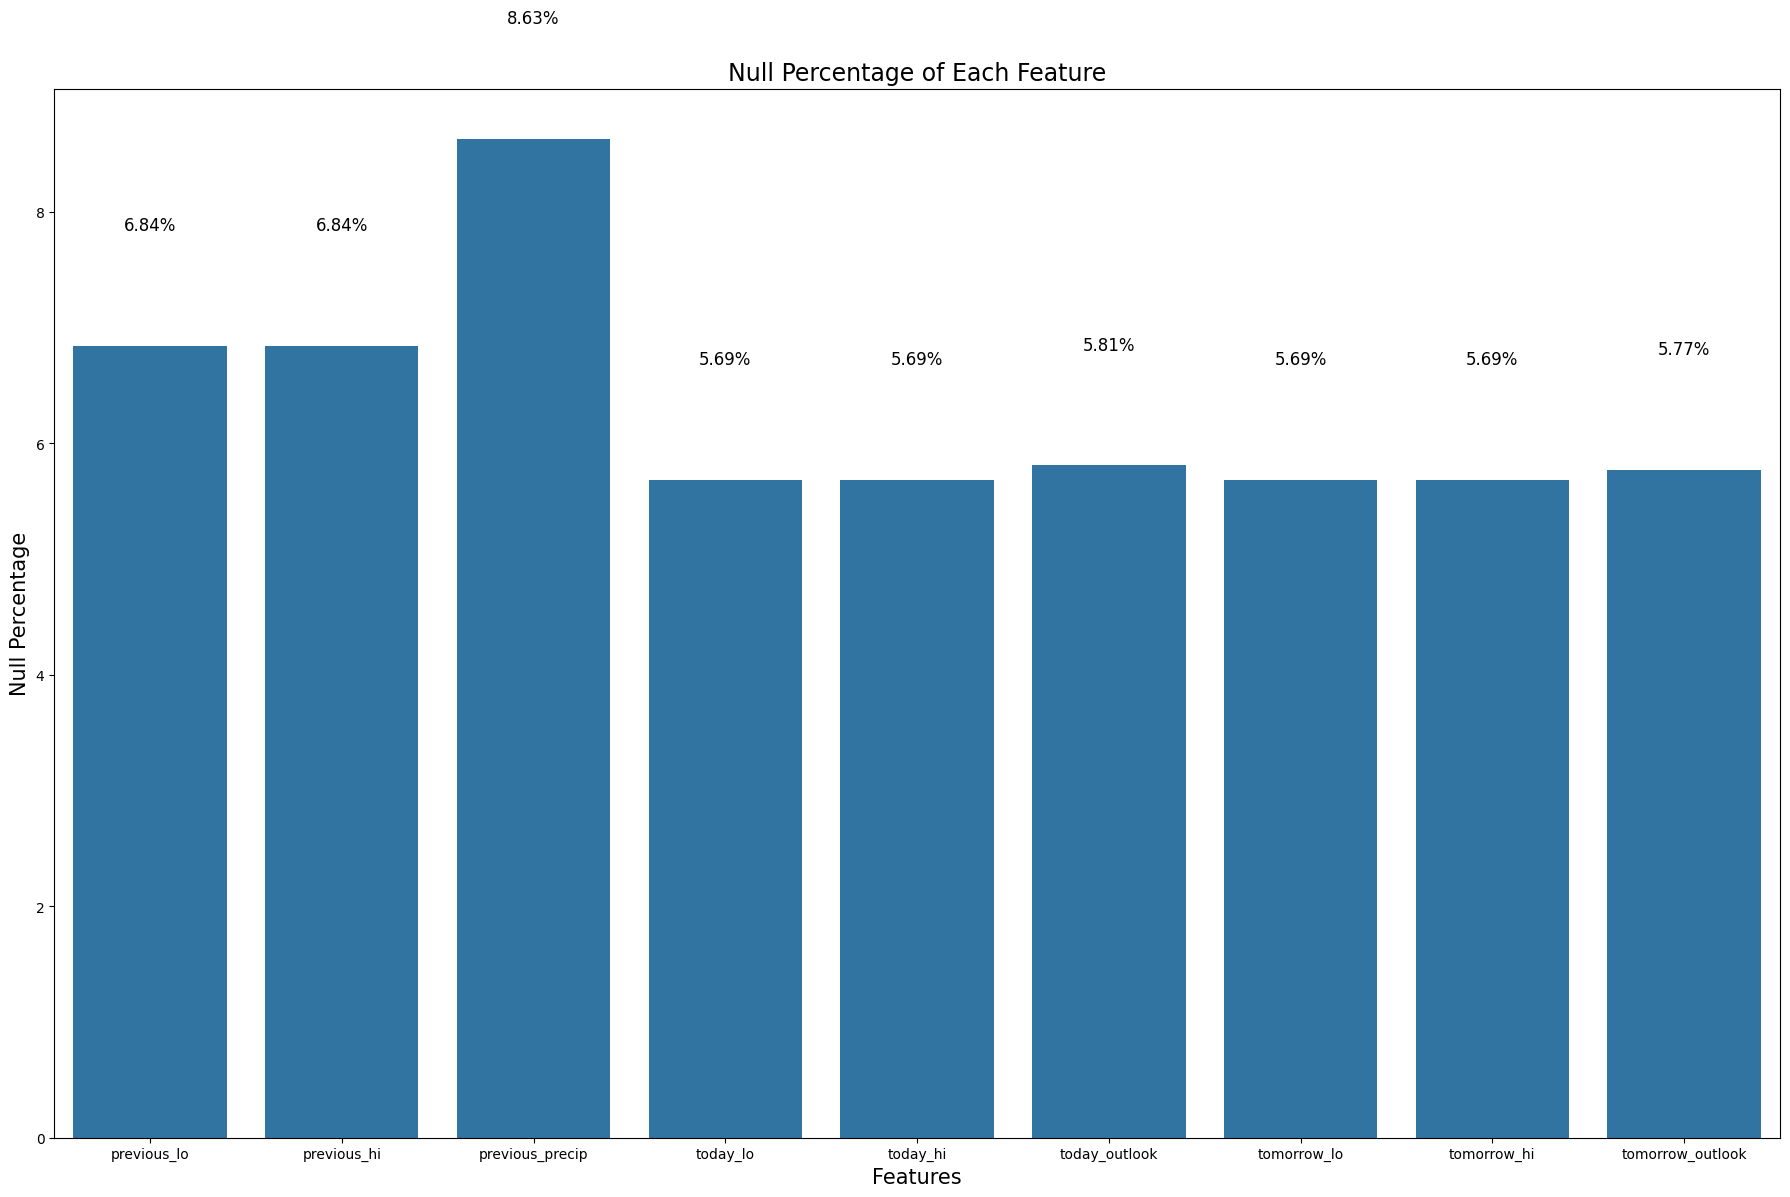

In [20]:
null_percentages = merged.isnull().mean() * 100
filtered_null_percentages = null_percentages[null_percentages > 0]

filtered_null_percentages

plt.figure(figsize = (18, 12))
ax = sns.barplot(x = filtered_null_percentages.index, y = filtered_null_percentages.values)

for i, v in enumerate(filtered_null_percentages):
    if v > 0:
        ax.text(i, v + 1, f"{v:.2f}%", ha = "center", size = 12)

plt.xlabel("Features", size = 15)
plt.ylabel("Null Percentage", size = 15)
plt.title("Null Percentage of Each Feature", size = 17)

plt.tight_layout()
plt.show()

#### lo and hi seem to be missing a lot for all days (previous, today, tomorrow) which causes the outlook to be missing too.

## Visualizations

In [21]:
grouped = merged.groupby("state").mean(numeric_only=True).reset_index()
grouped

,state,previous_lo,previous_hi,previous_precip,today_lo,today_hi,tomorrow_lo,tomorrow_hi,lon,lat,elevation,distance_to_coast,wind,elevation_change_four,elevation_change_eight,avg_annual_precip
0,AL,51.651698,71.478642,0.184744,51.612973,71.777297,51.745946,71.952432,-86.560,34.860000,229.310,295.220,3.630,24.230,96.220,59.0200
1,DC,51.154355,67.240353,0.128740,51.104575,67.272331,51.228758,67.262527,-77.030,38.850000,-0.670,0.350,4.180,111.600,117.200,48.5450
2,DE,46.939227,64.608840,0.121995,47.563181,64.336601,47.531590,64.604575,-75.610,39.670000,15.180,1.870,2.870,14.880,106.710,50.3800
3,GA,55.241758,76.160440,0.154665,55.674973,76.138678,55.689057,76.217768,-84.940,32.520000,120.540,157.820,2.170,36.670,108.690,54.4330
4,IL,44.422737,62.081678,0.110351,45.106754,62.334423,45.417211,62.671024,-89.680,39.850000,179.530,638.970,4.100,18.700,18.700,41.5110
5,ME,38.832599,55.115639,0.144513,39.422028,55.363141,39.412214,55.310796,-70.300,43.640000,5.950,0.930,3.160,69.410,69.410,52.7000
6,MO,47.243929,65.817881,0.135607,47.159041,66.116558,47.229847,66.417211,-93.390,37.240000,384.900,501.350,4.910,52.360,52.360,51.7770
7,MS,55.267544,76.023026,0.149176,55.561081,75.954595,55.641081,76.091892,-90.220,32.330000,93.650,133.820,3.770,25.520,27.390,58.9000
8,NH,37.254386,57.565789,0.122550,37.733478,57.320693,37.912243,57.482124,-71.500,43.200000,80.330,50.920,2.900,135.880,225.640,48.9460
9,NY,40.021429,56.604396,0.120238,40.730185,56.838762,40.751900,56.964169,-75.740,42.935000,123.715,171.070,3.685,69.720,100.055,41.5375


### Geographical location of each state

Text(0.5, 1.0, 'Location of Each State')

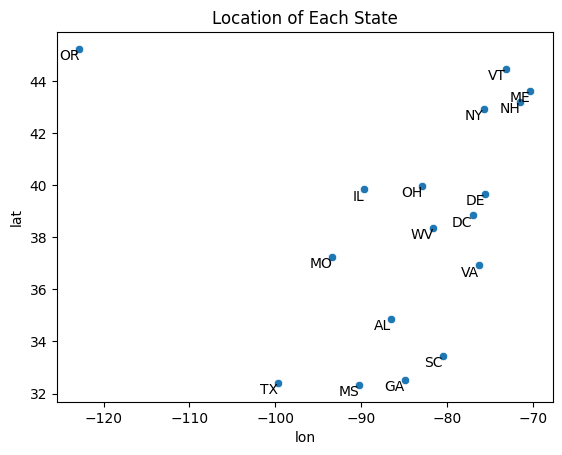

In [22]:
location = sns.scatterplot(data=grouped, x="lon", y="lat")

for i, label in enumerate(grouped["state"]):
    plt.text(grouped["lon"][i], grouped["lat"][i], label, fontsize=10, ha='right', va='top')
plt.title("Location of Each State")

### Elevation and temperature did not have as significant of a correlation according to this graphic

Text(0.5, 1.0, "Elevation vs Today's Lowest Temperature")

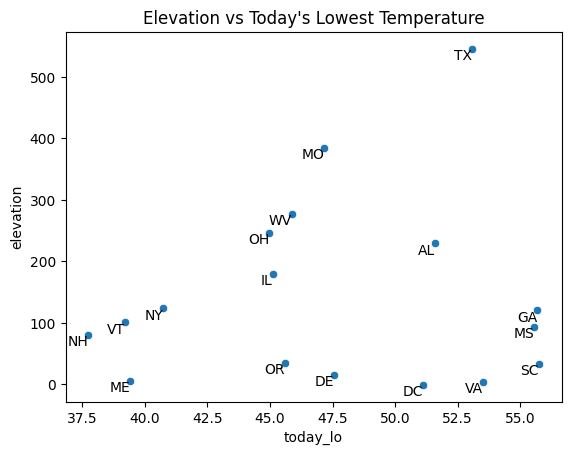

In [23]:
location = sns.scatterplot(data=grouped, x="today_lo", y="elevation")

for i, label in enumerate(grouped["state"]):
    plt.text(grouped["today_lo"][i], grouped["elevation"][i], label, fontsize=10, ha='right', va='top')
plt.title("Elevation vs Today's Lowest Temperature")


### Time Series Analysis of Lowest Temperature for Each State

In [ ]:
merged["date_and_time"] = pd.to_datetime(merged["date_and_time"])
merged["month"] = merged["date_and_time"].dt.month
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1 = sns.lineplot(data = merged, x="month", y="today_lo", hue = "state", ax = ax1)
ax2 = sns.lineplot(data = merged, x="month", y="today_hi", hue = "state", ax = ax2)
ax2.get_legend().remove()
plt.subplots_adjust(wspace=0.5)
ax1.legend(loc="right", bbox_to_anchor=(1.35, 0.5))

ax1.set_title("Average Lowest Temperature for Every Day / Month")
ax2.set_title("Average Highest Temperature for Every Day / Month")

### The lowest temperature is consistent among states and follows a quadratic curve where it goes up over the summer and goes down in the winter. The highest temperature varies by state slight, since some states have a low temperature in july. 

In [22]:
missing["date_and_time"] = pd.to_datetime(missing["date_and_time"])
missing["month"] = missing["date_and_time"].dt.month
num_missing_or = missing[(missing["city_state"] == "PORTLAND OR") & (missing["month"] == 7)]
num_missing_va = missing[(missing["city_state"] == "NORFOLK VA") & (missing["month"] == 7)]
num_missing_ny = missing[(missing["city_state"] == "ALBANY NY") & (missing["month"] == 7)]
num_missing_me = missing[(missing["city_state"] == "PORTLAND ME") & (missing["month"] == 7)]
(len(num_missing_or), len(num_missing_va), len(num_missing_ny), len(num_missing_me))

/tmp/ipykernel_8769/2956218269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing["date_and_time"] = pd.to_datetime(missing["date_and_time"])
/tmp/ipykernel_8769/2956218269.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing["month"] = missing["date_and_time"].dt.month


(4, 4, 4, 6)

### Time Series Analysis of Lowest and Highest Temperatures for Each State

The data is for 17 different states.

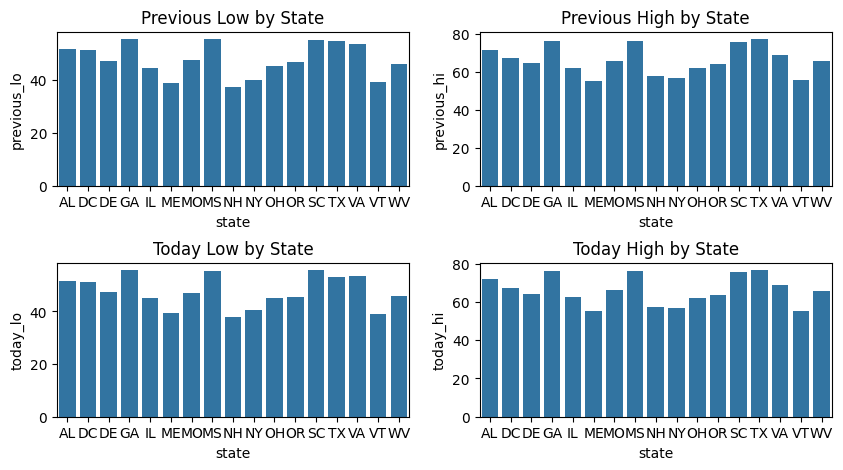

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 5))

ax1 = sns.barplot(data = grouped, x= "state", y = "previous_lo", ax=ax1)
ax1.set_title("Previous Low by State")

ax2 = sns.barplot(data = grouped, x= "state", y = "previous_hi", ax=ax2)
ax2.set_title("Previous High by State")

ax3 = sns.barplot(data = grouped, x= "state", y = "today_lo", ax=ax3)
ax3.set_title("Today Low by State")

ax4 = sns.barplot(data = grouped, x= "state", y = "today_hi", ax=ax4)
ax4.set_title("Today High by State")

plt.subplots_adjust(hspace = 0.5)

In [24]:
states = grouped["state"]
states.values

array(['AL', 'DC', 'DE', 'GA', 'IL', 'ME', 'MO', 'MS', 'NH', 'NY', 'OH',
       'OR', 'SC', 'TX', 'VA', 'VT', 'WV'], dtype=object)

In [28]:
merged

,date_and_time,city_state,previous_lo,previous_hi,previous_precip,today_lo,today_hi,today_outlook,tomorrow_lo,tomorrow_hi,...,lon,lat,koppen,elevation,distance_to_coast,wind,elevation_change_four,elevation_change_eight,avg_annual_precip,month
0,2021-01-30 07:50:00,ABILENE TX,54.0,64.0,0.0,39.0,70.0,DUST,32.0,60.0,...,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76,1
1,2021-01-30 19:50:00,ABILENE TX,54.0,70.0,0.0,38.0,59.0,SUNNY,32.0,60.0,...,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76,1
2,2021-01-31 07:50:00,ABILENE TX,42.0,70.0,0.0,32.0,59.0,SUNNY,38.0,60.0,...,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76,1
3,2021-01-31 19:50:00,ABILENE TX,40.0,60.0,0.0,31.0,60.0,SUNNY,38.0,67.0,...,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76,1
4,2021-02-01 07:50:00,ABILENE TX,31.0,60.0,0.0,37.0,60.0,SUNNY,45.0,67.0,...,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19515,2022-05-30 20:50:00,WILMINGTON DE,63.0,89.0,0.0,67.0,94.0,SUNNY,71.0,86.0,...,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38,5
19516,2022-05-31 08:50:00,WILMINGTON DE,68.0,89.0,0.0,71.0,94.0,SUNNY,68.0,86.0,...,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38,5
19517,2022-05-31 20:50:00,WILMINGTON DE,68.0,95.0,0.0,71.0,85.0,MOCLDY,69.0,84.0,...,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38,5
19518,2022-06-01 07:50:00,WILMINGTON DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38,6


In [29]:
merged["today_outlook"].unique()

array(['DUST', 'SUNNY', 'PTCLDY', 'WINDY', 'MOCLDY', 'CLOUDY', 'RNSNOW',
       'SNOW', nan, 'RAIN', 'SHWRS', 'FOG', 'TSTRMS', 'FZRAIN', 'SNOSHW',
       'BLZZRD', 'VRYCLD', 'FLRRYS', 'SLEET', 'DRZL', 'BLGSNO', 'VRYHOT',
       'FZDRZL', 'SMOKE'], dtype=object)

/tmp/ipykernel_8769/2412335648.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


Text(0.5, 1.0, 'Count of Outlooks')

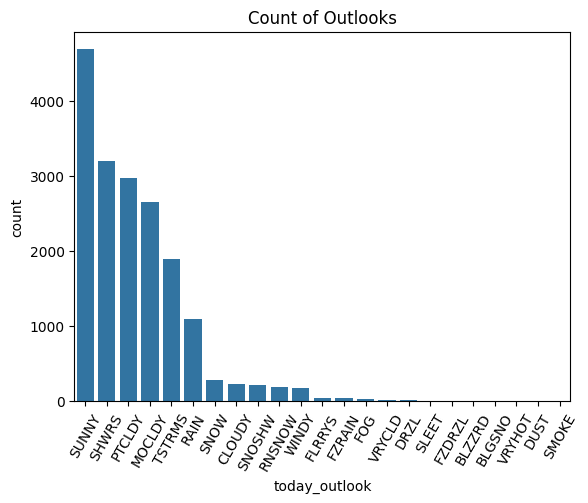

In [52]:
ax = sns.countplot(data=merged, x="today_outlook", order=merged['today_outlook'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.title("Count of Outlooks")

In [31]:
merged = merged.dropna()
merged

,date_and_time,city_state,previous_lo,previous_hi,previous_precip,today_lo,today_hi,today_outlook,tomorrow_lo,tomorrow_hi,...,lon,lat,koppen,elevation,distance_to_coast,wind,elevation_change_four,elevation_change_eight,avg_annual_precip,month
0,2021-01-30 07:50:00,ABILENE TX,54.0,64.0,0.0,39.0,70.0,DUST,32.0,60.0,...,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76,1
1,2021-01-30 19:50:00,ABILENE TX,54.0,70.0,0.0,38.0,59.0,SUNNY,32.0,60.0,...,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76,1
2,2021-01-31 07:50:00,ABILENE TX,42.0,70.0,0.0,32.0,59.0,SUNNY,38.0,60.0,...,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76,1
3,2021-01-31 19:50:00,ABILENE TX,40.0,60.0,0.0,31.0,60.0,SUNNY,38.0,67.0,...,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76,1
4,2021-02-01 07:50:00,ABILENE TX,31.0,60.0,0.0,37.0,60.0,SUNNY,45.0,67.0,...,-99.68,32.41,Cfa,545.46,328.89,4.43,66.72,66.72,26.76,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19514,2022-05-30 08:50:00,WILMINGTON DE,63.0,81.0,0.0,67.0,88.0,PTCLDY,71.0,93.0,...,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38,5
19515,2022-05-30 20:50:00,WILMINGTON DE,63.0,89.0,0.0,67.0,94.0,SUNNY,71.0,86.0,...,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38,5
19516,2022-05-31 08:50:00,WILMINGTON DE,68.0,89.0,0.0,71.0,94.0,SUNNY,68.0,86.0,...,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38,5
19517,2022-05-31 20:50:00,WILMINGTON DE,68.0,95.0,0.0,71.0,85.0,MOCLDY,69.0,84.0,...,-75.61,39.67,Cfa,15.18,1.87,2.87,14.88,106.71,50.38,5


In [32]:
merged["today_sunny"] = (merged["today_outlook"] == "SUNNY").astype(int)

X = merged[["today_lo", "today_hi", "elevation", "distance_to_coast", "wind", "month", "previous_lo", "previous_hi", "previous_precip"]]
y = merged["today_sunny"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7576609502389654


/tmp/ipykernel_8769/1553039516.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged["today_sunny"] = (merged["today_outlook"] == "SUNNY").astype(int)
/home/px/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Random Forest

In [33]:
cities = pd.read_csv("cities.csv")
weather = pd.read_csv("weather.csv")
cities = cities[cities['state'] == 'CA']

In [34]:

weather['city_states_'] = weather['city'].str.replace(' ', '_')
weather


,date_and_time,city,previous_lo,previous_hi,previous_precip,today_lo,today_hi,today_outlook,tomorrow_lo,tomorrow_hi,tomorrow_outlook,date,am_or_pm,city_states_
0,2021-01-30 07:50:00,ABILENE TX,54.0,64.0,0.00,39.0,70.0,DUST,32.0,60.0,SUNNY,2021-01-30,AM,ABILENE_TX
1,2021-01-30 07:50:00,AKRON CANTON,11.0,25.0,0.00,26.0,30.0,MOCLDY,28.0,30.0,SNOSHW,2021-01-30,AM,AKRON_CANTON
2,2021-01-30 07:50:00,ALBANY NY,-2.0,14.0,0.00,-1.0,18.0,SUNNY,9.0,22.0,PTCLDY,2021-01-30,AM,ALBANY_NY
3,2021-01-30 07:50:00,ALBUQUERQUE,32.0,55.0,0.00,26.0,48.0,SUNNY,26.0,50.0,SUNNY,2021-01-30,AM,ALBUQUERQUE
4,2021-01-30 07:50:00,ALLENTOWN,16.0,25.0,0.00,14.0,29.0,SUNNY,22.0,28.0,SNOW,2021-01-30,AM,ALLENTOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160059,2022-06-01 20:50:00,WILKES BARRE,66.0,85.0,0.33,64.0,78.0,SHWRS,56.0,74.0,PTCLDY,2022-06-01,PM,WILKES_BARRE
160060,2022-06-01 20:50:00,WILMINGTON DE,73.0,85.0,0.00,67.0,86.0,TSTRMS,66.0,79.0,SUNNY,2022-06-01,PM,WILMINGTON_DE
160061,2022-06-01 20:50:00,YAKIMA,49.0,79.0,0.00,55.0,80.0,TSTRMS,55.0,73.0,SHWRS,2022-06-01,PM,YAKIMA
160062,2022-06-01 20:50:00,YOUNGSTOWN,67.0,87.0,0.46,58.0,67.0,SHWRS,48.0,73.0,SUNNY,2022-06-01,PM,YOUNGSTOWN


In [35]:
cities['city_states_'] = cities['city']
cities


,city,state,lon,lat,koppen,elevation,distance_to_coast,wind,elevation_change_four,elevation_change_eight,avg_annual_precip,city_states_
76,FRESNO,CA,-119.7194,36.78000,BSk,102.17,123.02,2.49,23.71,29.80,10.480,FRESNO
123,LOS_ANGELES,CA,-118.2912,34.02355,Csb,53.58,11.76,1.28,77.14,701.73,12.420,LOS_ANGELES
178,RICHMOND,CA,-122.2480,37.87710,Csb,278.37,3.98,2.95,278.37,278.37,23.130,RICHMOND
185,SACRAMENTO,CA,-121.4959,38.50674,Csa,6.00,27.95,2.67,5.37,18.40,19.450,SACRAMENTO
191,SAN_DIEGO,CA,-117.1830,32.73361,BSk,4.24,0.75,1.15,107.91,293.42,11.056,SAN_DIEGO
192,SAN_FRANCISCO,CA,-122.4269,37.77056,Csb,48.60,2.80,2.48,145.26,273.80,22.070,SAN_FRANCISCO
193,SAN_JOSE,CA,-121.9241,37.35917,Csb,15.13,10.15,2.16,179.65,650.20,15.807,SAN_JOSE


In [36]:
merged_df = pd.merge(weather, cities, on='city_states_', how='left')
merged_df

,date_and_time,city_x,previous_lo,previous_hi,previous_precip,today_lo,today_hi,today_outlook,tomorrow_lo,tomorrow_hi,...,state,lon,lat,koppen,elevation,distance_to_coast,wind,elevation_change_four,elevation_change_eight,avg_annual_precip
0,2021-01-30 07:50:00,ABILENE TX,54.0,64.0,0.00,39.0,70.0,DUST,32.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-30 07:50:00,AKRON CANTON,11.0,25.0,0.00,26.0,30.0,MOCLDY,28.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-30 07:50:00,ALBANY NY,-2.0,14.0,0.00,-1.0,18.0,SUNNY,9.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-30 07:50:00,ALBUQUERQUE,32.0,55.0,0.00,26.0,48.0,SUNNY,26.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-30 07:50:00,ALLENTOWN,16.0,25.0,0.00,14.0,29.0,SUNNY,22.0,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160059,2022-06-01 20:50:00,WILKES BARRE,66.0,85.0,0.33,64.0,78.0,SHWRS,56.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160060,2022-06-01 20:50:00,WILMINGTON DE,73.0,85.0,0.00,67.0,86.0,TSTRMS,66.0,79.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160061,2022-06-01 20:50:00,YAKIMA,49.0,79.0,0.00,55.0,80.0,TSTRMS,55.0,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
160062,2022-06-01 20:50:00,YOUNGSTOWN,67.0,87.0,0.46,58.0,67.0,SHWRS,48.0,73.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
merged_df = merged_df[merged_df['city_states_'].isin(['FRESNO', 'LOS_ANGELES', 'RICHMOND', 'SACRAMENTO', 'SAN_DIEGO', 'SAN_FRANCISCO', 'SAN_JOSE']
)]

merged_df

,date_and_time,city_x,previous_lo,previous_hi,previous_precip,today_lo,today_hi,today_outlook,tomorrow_lo,tomorrow_hi,...,state,lon,lat,koppen,elevation,distance_to_coast,wind,elevation_change_four,elevation_change_eight,avg_annual_precip
38,2021-01-30 07:50:00,LOS ANGELES,44.0,54.0,0.43,46.0,62.0,SUNNY,52.0,69.0,...,CA,-118.2912,34.02355,Csb,53.58,11.76,1.28,77.14,701.73,12.420
75,2021-01-30 07:50:00,RICHMOND,18.0,36.0,0.00,27.0,41.0,SUNNY,34.0,36.0,...,CA,-122.2480,37.87710,Csb,278.37,3.98,2.95,278.37,278.37,23.130
79,2021-01-30 07:50:00,SACRAMENTO,40.0,53.0,0.09,43.0,57.0,MOCLDY,46.0,60.0,...,CA,-121.4959,38.50674,Csa,6.00,27.95,2.67,5.37,18.40,19.450
103,2021-01-30 07:50:00,FRESNO,40.0,56.0,0.01,39.0,56.0,PTCLDY,47.0,59.0,...,CA,-119.7194,36.78000,BSk,102.17,123.02,2.49,23.71,29.80,10.480
131,2021-01-30 07:50:00,SAN DIEGO,46.0,62.0,0.30,45.0,62.0,SUNNY,49.0,66.0,...,CA,-117.1830,32.73361,BSk,4.24,0.75,1.15,107.91,293.42,11.056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160019,2022-06-01 20:50:00,RICHMOND,71.0,96.0,0.00,71.0,94.0,TSTRMS,66.0,82.0,...,CA,-122.2480,37.87710,Csb,278.37,3.98,2.95,278.37,278.37,23.130
160023,2022-06-01 20:50:00,SACRAMENTO,58.0,94.0,0.00,60.0,92.0,PTCLDY,58.0,82.0,...,CA,-121.4959,38.50674,Csa,6.00,27.95,2.67,5.37,18.40,19.450
160031,2022-06-01 20:50:00,SAN DIEGO,60.0,67.0,0.00,59.0,72.0,PTCLDY,59.0,71.0,...,CA,-117.1830,32.73361,BSk,4.24,0.75,1.15,107.91,293.42,11.056
160032,2022-06-01 20:50:00,SAN FRANCISCO,52.0,72.0,0.00,54.0,70.0,PTCLDY,56.0,69.0,...,CA,-122.4269,37.77056,Csb,48.60,2.80,2.48,145.26,273.80,22.070


In [38]:
merged_df['date_and_time'] = pd.to_datetime(merged_df['date_and_time'])

merged_df['date_and_time_numerical'] = merged_df['date_and_time'].astype('int64') // 10**9
merged_df = merged_df.drop('date_and_time', axis=1)
merged_df = merged_df.dropna()
merged_df

/tmp/ipykernel_8769/470938221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['date_and_time'] = pd.to_datetime(merged_df['date_and_time'])
/tmp/ipykernel_8769/470938221.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['date_and_time_numerical'] = merged_df['date_and_time'].astype('int64') // 10**9


,city_x,previous_lo,previous_hi,previous_precip,today_lo,today_hi,today_outlook,tomorrow_lo,tomorrow_hi,tomorrow_outlook,...,lon,lat,koppen,elevation,distance_to_coast,wind,elevation_change_four,elevation_change_eight,avg_annual_precip,date_and_time_numerical
38,LOS ANGELES,44.0,54.0,0.43,46.0,62.0,SUNNY,52.0,69.0,MOCLDY,...,-118.2912,34.02355,Csb,53.58,11.76,1.28,77.14,701.73,12.420,1611993000
75,RICHMOND,18.0,36.0,0.00,27.0,41.0,SUNNY,34.0,36.0,SNOW,...,-122.2480,37.87710,Csb,278.37,3.98,2.95,278.37,278.37,23.130,1611993000
79,SACRAMENTO,40.0,53.0,0.09,43.0,57.0,MOCLDY,46.0,60.0,MOCLDY,...,-121.4959,38.50674,Csa,6.00,27.95,2.67,5.37,18.40,19.450,1611993000
103,FRESNO,40.0,56.0,0.01,39.0,56.0,PTCLDY,47.0,59.0,MOCLDY,...,-119.7194,36.78000,BSk,102.17,123.02,2.49,23.71,29.80,10.480,1611993000
131,SAN DIEGO,46.0,62.0,0.30,45.0,62.0,SUNNY,49.0,66.0,PTCLDY,...,-117.1830,32.73361,BSk,4.24,0.75,1.15,107.91,293.42,11.056,1611993000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160019,RICHMOND,71.0,96.0,0.00,71.0,94.0,TSTRMS,66.0,82.0,TSTRMS,...,-122.2480,37.87710,Csb,278.37,3.98,2.95,278.37,278.37,23.130,1654116600
160023,SACRAMENTO,58.0,94.0,0.00,60.0,92.0,PTCLDY,58.0,82.0,PTCLDY,...,-121.4959,38.50674,Csa,6.00,27.95,2.67,5.37,18.40,19.450,1654116600
160031,SAN DIEGO,60.0,67.0,0.00,59.0,72.0,PTCLDY,59.0,71.0,MOCLDY,...,-117.1830,32.73361,BSk,4.24,0.75,1.15,107.91,293.42,11.056,1654116600
160032,SAN FRANCISCO,52.0,72.0,0.00,54.0,70.0,PTCLDY,56.0,69.0,MOCLDY,...,-122.4269,37.77056,Csb,48.60,2.80,2.48,145.26,273.80,22.070,1654116600


In [39]:
category_mapping = {
    'SUNNY': 'Sunny/Bright', 
    'PTCLDY': 'Sunny/Bright', 
    'MOCLDY': 'Cloudy', 
    'CLOUDY': 'Cloudy', 
    'FOG': 'Cloudy',
    'SHWRS': 'Precipitation', 
    'RAIN': 'Precipitation', 
    'TSTRMS': 'Precipitation', 
    'RNSNOW': 'Precipitation', 
    'SNOW': 'Precipitation', 
    'FZRAIN': 'Precipitation', 
    'FZDRZL': 'Precipitation',
    'WINDY': 'Extreme/Other', 
    'SMOKE': 'Extreme/Other', 
    'VRYHOT': 'Extreme/Other', 
    'DUST': 'Extreme/Other'
}

merged_df['today_outlook'] = merged_df['today_outlook'].map(category_mapping)
print(merged_df['today_outlook'].value_counts())

today_outlook
Sunny/Bright     4186
Cloudy           1068
Precipitation     834
Extreme/Other     135
Name: count, dtype: int64


In [40]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter

le = LabelEncoder()
mergings = merged_df.copy()
mergings['today_outlook_encoded'] = le.fit_transform(mergings['today_outlook'])

X = mergings.drop(['today_outlook', 'today_outlook_encoded'], axis=1)
y = mergings['today_outlook_encoded']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns

X_encoded = pd.get_dummies(X, columns=categorical_cols)

print("Before SMOTE:", Counter(y))

smote = SMOTE()
X_res, y_res = smote.fit_resample(X_encoded, y)

print("After SMOTE:", Counter(y_res))

balanced_df = pd.DataFrame(X_res, columns=X_encoded.columns)
balanced_df['today_outlook'] = y_res


Before SMOTE: Counter({3: 4186, 0: 1068, 2: 834, 1: 135})
After SMOTE: Counter({3: 4186, 0: 4186, 2: 4186, 1: 4186})


/tmp/ipykernel_8769/3145713803.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_df['today_outlook'] = y_res


In [41]:
balanced_df

,previous_lo,previous_hi,previous_precip,today_lo,today_hi,tomorrow_lo,tomorrow_hi,lon,lat,elevation,...,city_y_RICHMOND,city_y_SACRAMENTO,city_y_SAN_DIEGO,city_y_SAN_FRANCISCO,city_y_SAN_JOSE,state_CA,koppen_BSk,koppen_Csa,koppen_Csb,today_outlook
0,44.000000,54.000000,0.430000,46.000000,62.000000,52.000000,69.000000,-118.291200,34.023550,53.580000,...,False,False,False,False,False,True,False,False,True,3
1,18.000000,36.000000,0.000000,27.000000,41.000000,34.000000,36.000000,-122.248000,37.877100,278.370000,...,True,False,False,False,False,True,False,False,True,3
2,40.000000,53.000000,0.090000,43.000000,57.000000,46.000000,60.000000,-121.495900,38.506740,6.000000,...,False,True,False,False,False,True,False,True,False,0
3,40.000000,56.000000,0.010000,39.000000,56.000000,47.000000,59.000000,-119.719400,36.780000,102.170000,...,False,False,False,False,False,True,True,False,False,3
4,46.000000,62.000000,0.300000,45.000000,62.000000,49.000000,66.000000,-117.183000,32.733610,4.240000,...,False,False,True,False,False,True,True,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16739,54.877223,69.728890,0.243478,54.851666,67.987221,49.122777,67.838888,-122.248000,37.877100,278.370000,...,True,False,False,False,False,True,False,False,True,2
16740,40.696022,60.839963,0.000000,48.000000,53.232007,39.535985,51.000000,-119.925481,36.980308,91.013927,...,False,True,False,False,False,True,True,True,False,2
16741,48.413878,70.413878,0.015861,50.793061,66.379182,41.206939,70.379182,-121.584511,38.269263,7.889355,...,False,True,False,False,True,True,False,True,True,2
16742,43.083987,68.000000,0.000000,43.050392,65.966405,43.016797,66.000000,-122.248000,37.877100,278.370000,...,True,False,False,False,False,True,False,False,True,2


In [42]:
tomorrowss = [col for col in balanced_df if "tomorrow_outlook" in col]

cityss = [col for col in balanced_df if "city_" in col]

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

mergings = balanced_df.copy()
sampled_df = mergings

X = sampled_df[['previous_lo','previous_hi','previous_precip','lon','lat','elevation','wind','avg_annual_precip','date_and_time_numerical','distance_to_coast','today_lo','today_hi','elevation_change_four']]  # Features
y = sampled_df['today_outlook']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8714171974522293


# Gradient Boosting

Accuracy: 0.8871417197452229


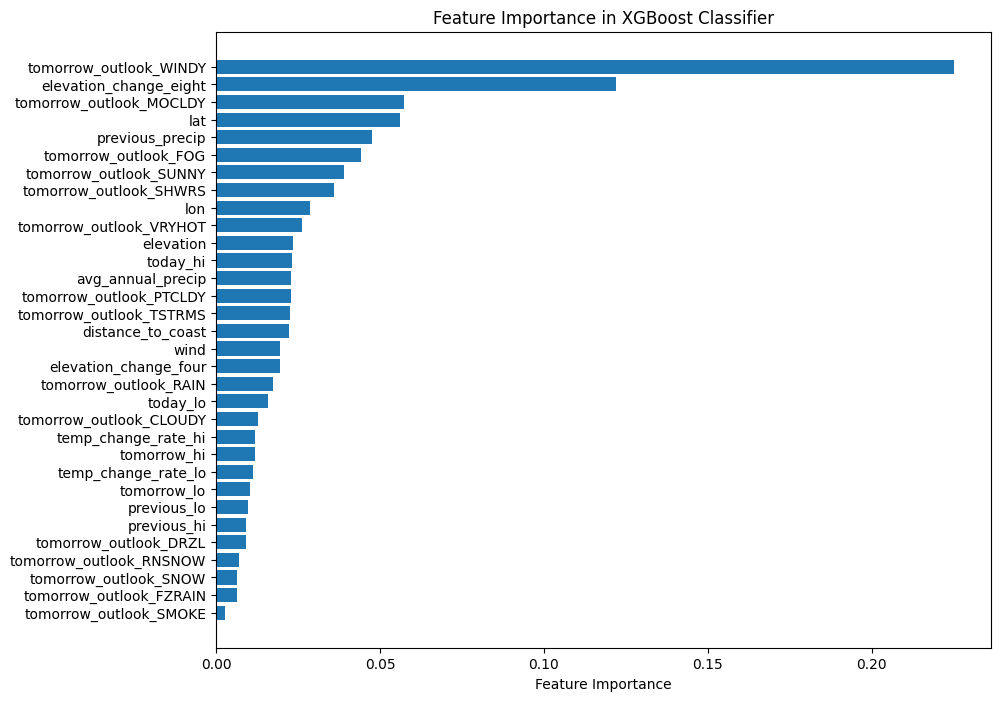

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
mergings = balanced_df.copy()
sampled_df = mergings
sampled_df['temp_change_rate_hi'] = (sampled_df['today_hi'] - sampled_df['previous_hi'])
sampled_df['temp_change_rate_lo'] = (sampled_df['today_lo'] - sampled_df['previous_lo'])
feature_columns = ['temp_change_rate_hi', 'temp_change_rate_lo','previous_lo','previous_hi','previous_precip','today_lo','today_hi','lon','lat','elevation','distance_to_coast','wind','elevation_change_four','elevation_change_eight','avg_annual_precip'] + tomorrowss 
X = sampled_df[feature_columns] 
y = sampled_df['today_outlook'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgb_classifier = XGBClassifier(n_estimators=100, random_state=42)

xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

feature_importance = xgb_classifier.feature_importances_
sorted_idx = feature_importance.argsort()
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_columns[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in XGBoost Classifier')
plt.show()

# RNN

In [47]:
df=balanced_df.copy()

X = df.drop('today_outlook', axis=1)
y = df['today_outlook']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the RNN model
model = Sequential()
model.add(LSTM(50, input_shape=(1, X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))  
model.add(LSTM(30, return_sequences=False))
model.add(Dropout(0.3))  
model.add(Dense(10, activation='relu'))
model.add(Dense(4, activation='softmax'))  

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model.fit(X_train_scaled, y_train, epochs=6000, batch_size=2000, validation_split=0.1)
# model.evaluate(X_test_scaled, y_test)


early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=200, validation_split=0.1, callbacks=[early_stopping])
model.evaluate(X_test_scaled, y_test)


Epoch 1/50
61/61 [==============================] - 2s 9ms/step - loss: 1.3103 - accuracy: 0.4531 - val_loss: 1.1415 - val_accuracy: 0.6918
Epoch 2/50
61/61 [==============================] - 0s 3ms/step - loss: 0.9129 - accuracy: 0.7560 - val_loss: 0.6599 - val_accuracy: 0.8224
Epoch 3/50
61/61 [==============================] - 0s 3ms/step - loss: 0.5101 - accuracy: 0.8449 - val_loss: 0.4077 - val_accuracy: 0.8627
Epoch 4/50
61/61 [==============================] - 0s 3ms/step - loss: 0.3530 - accuracy: 0.8774 - val_loss: 0.3352 - val_accuracy: 0.8813
Epoch 5/50
61/61 [==============================] - 0s 3ms/step - loss: 0.2754 - accuracy: 0.9058 - val_loss: 0.3004 - val_accuracy: 0.8851
Epoch 6/50
61/61 [==============================] - 0s 3ms/step - loss: 0.2263 - accuracy: 0.9222 - val_loss: 0.2887 - val_accuracy: 0.8993
Epoch 7/50
61/61 [==============================] - 0s 3ms/step - loss: 0.1880 - accuracy: 0.9349 - val_loss: 0.2898 - val_accuracy: 0.8940
Epoch 8/50
61/61 [==

[0.2963477671146393, 0.9125111699104309]

## Wtihout Cities
# ATTENTION <br />DON'T RUN THE CODE BELOW WITHOUT AN NVIDIA GPU

In [49]:
df=balanced_df.copy()
X = df[['previous_lo','previous_hi','previous_precip','lon','lat','elevation','wind','avg_annual_precip','date_and_time_numerical','distance_to_coast','today_lo','today_hi','elevation_change_four']]  # Features
#X = df.drop('today_outlook', axis=1)
y = df['today_outlook']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the RNN model
model = Sequential()
model.add(LSTM(50, input_shape=(1, X_train_scaled.shape[2]), return_sequences=True))
model.add(Dropout(0.3))  
model.add(LSTM(30, return_sequences=False))
model.add(Dropout(0.3))  
model.add(Dense(10, activation='relu'))
model.add(Dense(4, activation='softmax'))  

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model don't run it without GPU!!! 
model.fit(X_train_scaled, y_train, epochs=6000, batch_size=2000, validation_split=0.1)
model.evaluate(X_test_scaled, y_test)


# early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# history = model.fit(X_train_scaled, y_train, epochs=500, batch_size=200, validation_split=0.1, callbacks=[early_stopping])

model.evaluate(X_test_scaled, y_test)


Epoch 1/6000
7/7 [==============================] - 2s 58ms/step - loss: 1.3846 - accuracy: 0.2540 - val_loss: 1.3773 - val_accuracy: 0.2821
Epoch 2/6000
7/7 [==============================] - 0s 6ms/step - loss: 1.3765 - accuracy: 0.2842 - val_loss: 1.3675 - val_accuracy: 0.3097
Epoch 3/6000
7/7 [==============================] - 0s 7ms/step - loss: 1.3670 - accuracy: 0.3095 - val_loss: 1.3559 - val_accuracy: 0.3828
Epoch 4/6000
7/7 [==============================] - 0s 6ms/step - loss: 1.3558 - accuracy: 0.3532 - val_loss: 1.3411 - val_accuracy: 0.4209
Epoch 5/6000
7/7 [==============================] - 0s 6ms/step - loss: 1.3415 - accuracy: 0.3948 - val_loss: 1.3228 - val_accuracy: 0.4022
Epoch 6/6000
7/7 [==============================] - 0s 6ms/step - loss: 1.3239 - accuracy: 0.4218 - val_loss: 1.3010 - val_accuracy: 0.4396
Epoch 7/6000
7/7 [==============================] - 0s 6ms/step - loss: 1.3038 - accuracy: 0.4408 - val_loss: 1.2760 - val_accuracy: 0.4694
Epoch 8/6000
7/7 [=

[0.4119194746017456, 0.8369662761688232]